In [36]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform
from matplotlib import pyplot as plt
from scipy import misc
from skimage import exposure
from scipy import ndimage
from skimage import feature
from skimage import filters

data_dir = 'data/proj1-data/'

In [37]:
frame_size = 60

In [38]:
def roll_img(im, vdisp, hdisp):
    new_im1 = np.roll(im, vdisp, axis=0)
    new_im1 = np.roll(new_im1, hdisp, axis=1)
    return new_im1

In [47]:
def sum_of_squared_diff(im1, im2):
    mid_height, mid_width = int(im1.shape[0] / 2), int(im1.shape[1] / 2)
    cropped_im1 = im1 [mid_height - frame_size : mid_height + frame_size, mid_width - frame_size : mid_width + frame_size]
    cropped_im2 = im2 [mid_height - frame_size : mid_height + frame_size, mid_width - frame_size : mid_width + frame_size]
    loss = np.sum((cropped_im1 - cropped_im2) ** 2)
    return loss

def ncc(im1, im2):
    mid_height, mid_width = int(im1.shape[0] / 2), int(im1.shape[1] / 2)
    cropped_im1 = im1 [mid_height - frame_size : mid_height + frame_size, mid_width - frame_size : mid_width + frame_size]
    cropped_im2 = im2 [mid_height - frame_size : mid_height + frame_size, mid_width - frame_size : mid_width + frame_size]
    cropped_im1 -= np.mean(cropped_im1)
    cropped_im2 -= np.mean(cropped_im2)
    normed_crop_im1 = cropped_im1 / np.linalg.norm(cropped_im1)
    normed_crop_im2 = cropped_im2 / np.linalg.norm(cropped_im2)
    similarity = np.sum(normed_crop_im1 * normed_crop_im2)
    return -similarity

In [48]:
def score (im1, im2, vdisp, hdisp, score_fn):
    im1, im2 = np.array(im1), np.array(im2)
    new_im1 = roll_img(im1, vdisp, hdisp)
    return score_fn(new_im1, im2)

In [49]:
def get_disp (im1, im2, loss_fn=sum_of_squared_diff, max_disp = 15):
    min_score = float('inf')
    min_disp = (0,0)
    for vdisp in range(-max_disp, max_disp):
        for hdisp in range(-max_disp, max_disp):
                curr_score = score(im1, im2, vdisp, hdisp, loss_fn)
                if curr_score < min_score:
                    min_score = curr_score
                    min_disp = (vdisp, hdisp)
    return (min_disp[0], min_disp[1])

def align(im1, im2, loss_fn=sum_of_squared_diff, max_disp = 15, big=False, name=None):
    vdisp, hdisp = None, None
    if not big:
        vdisp, hdisp = get_disp(im1, im2, loss_fn = loss_fn, max_disp = max_disp)
        
    else:
        vdisp, hdisp = get_disp_big(im1, im2, loss_fn, max_disp, name=name)
    print("Displacement - Vertical: {0}; Horizontal: {1}".format(vdisp, hdisp))
    return roll_img(im1, vdisp, hdisp)


In [50]:
def get_bgr(image_name):
    # name of the input file
    imname = data_dir + image_name

    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    return b,g,r

def align_img(image_name, loss_fn=sum_of_squared_diff, max_disp = 15, big=False, name=None, hist_eq = False):
    b,g,r = get_bgr(image_name)
    
    if hist_eq == True:
        b, g, r = exposure.equalize_hist(b), exposure.equalize_hist(g), exposure.equalize_hist(r)
    
    print("Aligning green and blue: ")
    ag = align(g, b, loss_fn=loss_fn, max_disp = max_disp, big=big, name=name)
    print("Aligning blue and red: ")
    ar = align(r, b, loss_fn=loss_fn, max_disp = max_disp, big=big, name=name)
    # create a color image
    im_out = np.dstack([ar, ag, b])
    plt.show()

    # save the image
    iname = image_name.split('.')
    iname[-1] = 'jpg'
    image_name = '.'.join(iname)
    fname = 'out_' + image_name
    skio.imsave(fname, im_out)

    # display the image
    skio.imshow(im_out)
    plt.show()
    skio.show()   



In [51]:
def get_disp_big(im1, im2, loss_fn, max_disp, name=None):
    # Use an edge detector with sigma 1 (catered for Emir)
    if name == "emir-bw-sigma-1" or name == "lady":
        curr_im1 = feature.canny(im1, sigma=1)
        curr_im2 = feature.canny(im2, sigma=1)
        
        plt.imshow(curr_im1, cmap="gray")
        plt.show()
        plt.imshow(curr_im2, cmap="gray")
        plt.show()
        
    # Edge detector with sigma 5 (catered for Emir)
    elif name == "emir-bw-sigma-5":
        curr_im1 = feature.canny(im1, sigma=5)
        curr_im2 = feature.canny(im2, sigma=5)
        
        plt.imshow(curr_im1, cmap="gray")
        plt.show()
        plt.imshow(curr_im2, cmap="gray")
        plt.show()
        
    else:
        curr_im1 = im1.copy()
        curr_im2 = im2.copy()
    
    down_scale = 1
    im1s = [curr_im1]
    im2s = [curr_im2]
    scales = [down_scale]
    vdisp = 0
    hdisp = 0
    
    while (curr_im1.shape[0] > 300): 
        curr_im1 = skimage.transform.rescale(curr_im1, 0.5)
        curr_im2 = skimage.transform.rescale(curr_im2, 0.5)
        down_scale *= 2
        
        im1s.append(curr_im1)
        im2s.append(curr_im2)
        scales.append(down_scale)
    
    curr_disp = max_disp
    print("Downscaled {0} times".format(len(scales) - 1))
    
    for curr_im_idx in range(len(scales) - 1, -1, -1):
        
        curr_im1, curr_im2, down_scale = im1s[curr_im_idx], im2s[curr_im_idx], scales[curr_im_idx]
        
#         print("Total vdisp", vdisp)
#         print("Total hdisp", hdisp)
#         print("Current downscale", down_scale)
#         print("Max search frame", curr_disp)
        curr_im1 = roll_img(curr_im1, int(vdisp / down_scale), int(hdisp / down_scale))
        
        curr_vdisp, curr_hdisp = get_disp(curr_im1, curr_im2, loss_fn = loss_fn, max_disp = curr_disp)
        
        vdisp += curr_vdisp * down_scale
        hdisp += curr_hdisp * down_scale
        
        curr_disp = max(1, int(curr_disp / 2))
        
    return (vdisp, hdisp)


        
        
    

### Small Images i.e. '.jpg'

Aligning green and blue: 
Displacement - Vertical: 5; Horizontal: 2
Aligning blue and red: 
Displacement - Vertical: 12; Horizontal: 3


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


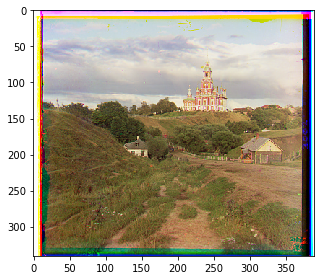

In [52]:
align_img("cathedral.jpg", loss_fn=sum_of_squared_diff)

Aligning green and blue: 
Displacement - Vertical: -3; Horizontal: 2
Aligning blue and red: 
Displacement - Vertical: 3; Horizontal: 2


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


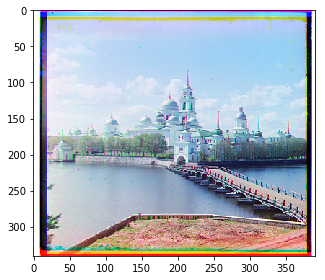

In [53]:
align_img("monastery.jpg", loss_fn=ncc)

Aligning green and blue: 
Displacement - Vertical: 7; Horizontal: 0
Aligning blue and red: 
Displacement - Vertical: 14; Horizontal: -1


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


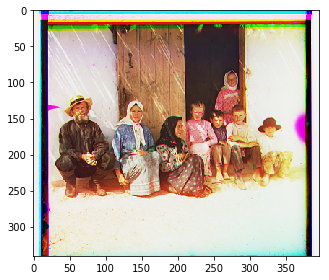

In [46]:
align_img("settlers.jpg", loss_fn=ncc)

Aligning green and blue: 
Displacement - Vertical: 3; Horizontal: 1
Aligning blue and red: 
Displacement - Vertical: 8; Horizontal: 0


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


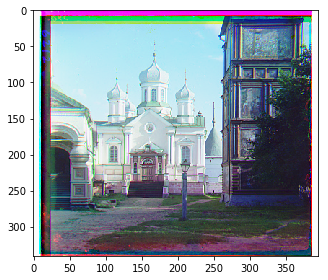

In [39]:
align_img("nativity.jpg", loss_fn=ncc)

### Large Images i.e. '.tif'

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 58; Horizontal: 16
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 124; Horizontal: 16


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


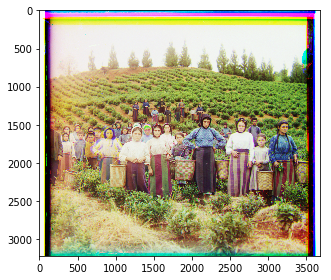

In [22]:
# Perfect
align_img("harvesters.tif", max_disp=8, big=True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 47; Horizontal: 23
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 236; Horizontal: -198


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


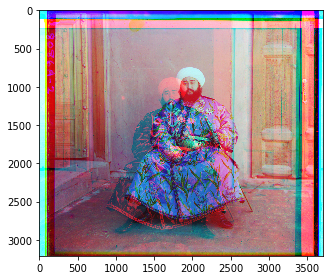

In [11]:
align_img("emir.tif", loss_fn=ncc, max_disp=16, big=True)

Aligning green and blue: 


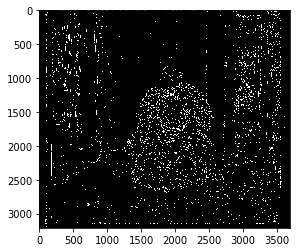

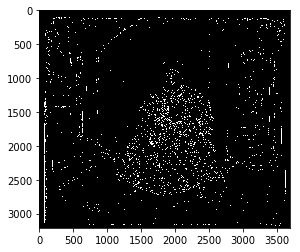

/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 48; Horizontal: 23
Aligning blue and red: 


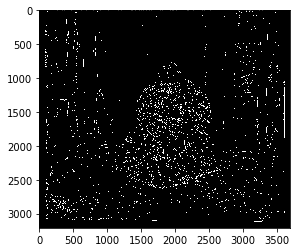

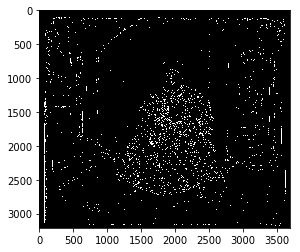

Downscaled 4 times
Displacement - Vertical: 105; Horizontal: 40


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


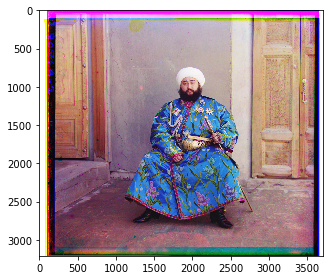

In [43]:
align_img("emir-bw-sigma-1.tif", loss_fn=ncc, max_disp=8, big=True, name="emir-bw-sigma-1")

Aligning green and blue: 


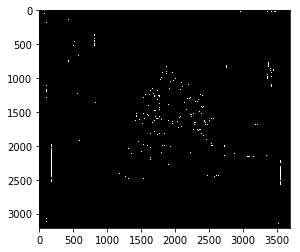

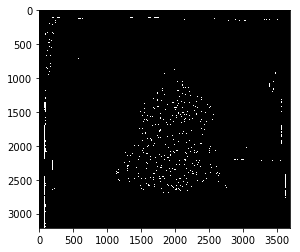

/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 47; Horizontal: 23
Aligning blue and red: 


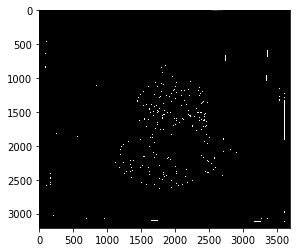

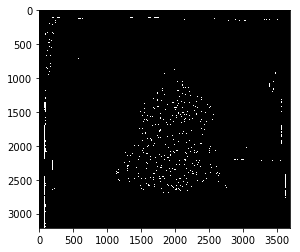

Downscaled 4 times
Displacement - Vertical: 107; Horizontal: 40


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


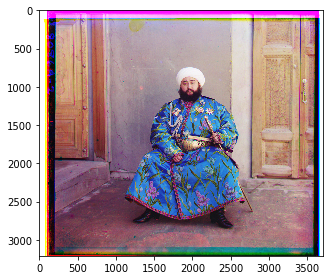

In [44]:
align_img("emir-bw-sigma-5.tif", loss_fn=ncc, max_disp=8, big=True, name="emir-bw-sigma-5")

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 40; Horizontal: 18
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 88; Horizontal: 23


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


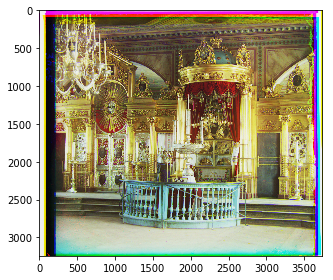

In [13]:
# Perfect
align_img("icon.tif", big=True, max_disp = 8)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 51; Horizontal: 6
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 111; Horizontal: 8


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


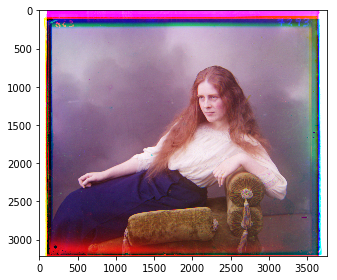

In [13]:
# Perfect
align_img("lady.tif", max_disp=8, big=True, loss_fn = ncc)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 51; Horizontal: 6
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 116; Horizontal: 0


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


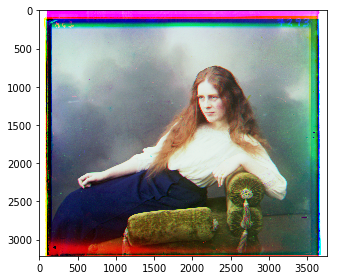

In [15]:
# Perfect
align_img("lady-bw-hist-eq.tif", max_disp=8, big=True, loss_fn = ncc, hist_eq = True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 77; Horizontal: 29
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 175; Horizontal: 37


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


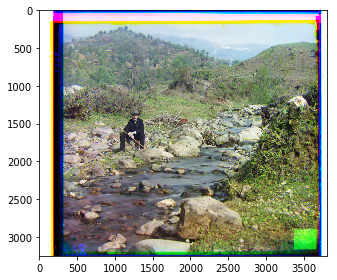

In [17]:
# Perfect
align_img("self_portrait.tif", loss_fn = ncc, max_disp=16, big=True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 48; Horizontal: 16
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 108; Horizontal: 11


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


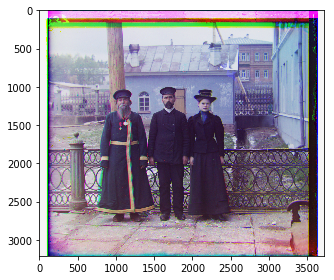

In [23]:
# Perfect
align_img("three_generations.tif", loss_fn = ncc, max_disp=8, big=True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 42; Horizontal: 6
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 84; Horizontal: 32


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


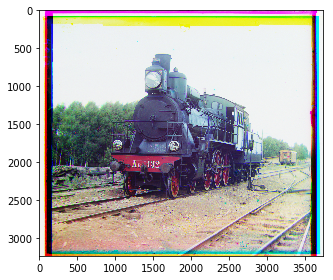

In [24]:
# Perfect
align_img("train.tif", loss_fn = ncc, max_disp=8, big=True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 56; Horizontal: 22
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 116; Horizontal: 28


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


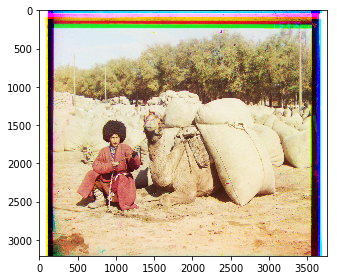

In [25]:
# Perfect
align_img("turkmen.tif", loss_fn = ncc, max_disp=8, big=True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 64; Horizontal: 12
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 136; Horizontal: 22


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


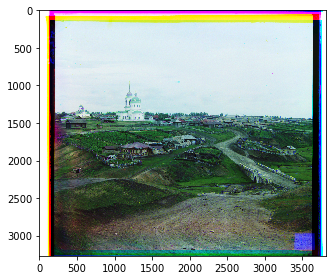

In [26]:
# Perfect
align_img("village.tif", loss_fn = ncc, max_disp=8, big=True)

Aligning green and blue: 


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Downscaled 4 times
Displacement - Vertical: 70; Horizontal: -3
Aligning blue and red: 
Downscaled 4 times
Displacement - Vertical: 121; Horizontal: -23


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


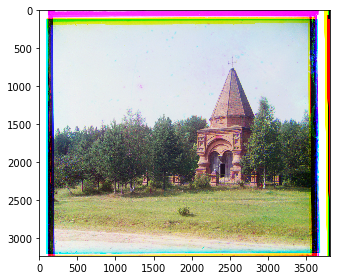

In [27]:
align_img("chapel_ivan.tif", loss_fn = ncc, max_disp=8, big=True)

Aligning green and blue: 
Displacement - Vertical: 0; Horizontal: 1
Aligning blue and red: 
Displacement - Vertical: 1; Horizontal: 2


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


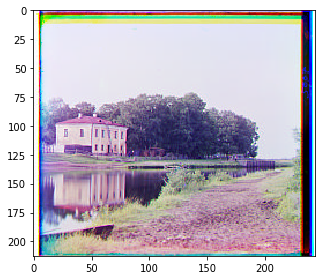

In [28]:
align_img("floodgate.jpg", loss_fn = ncc, max_disp=15, big=False)

Aligning green and blue: 
Displacement - Vertical: 1; Horizontal: -1
Aligning blue and red: 
Displacement - Vertical: 7; Horizontal: -2


/home/girish/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/girish/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


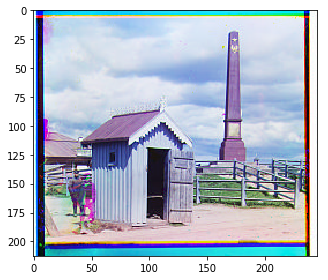

In [29]:
align_img("monument.jpg", loss_fn = ncc, max_disp=15, big=False)